In [134]:
class Simulation:
    def __init__(self, rows, columns, drones, turns, max_payload, product_types, warehouses, orders):
        self.rows = rows
        self.columns = columns
        self.drones = drones
        self.turns = turns
        self.max_payload = max_payload
        self.product_types = product_types
        self.warehouses = warehouses
        self.orders = orders

    def sort_orders(self):
        self.orders.sort(key=lambda x: sum(x.inventory.values())) 
        self.orders.sort(key=lambda x: sum([self.product_types[product_type].weight * quantity for product_type, quantity in x.inventory.items()])) # trier par poids en ordre croissant
        self.orders.sort(key=lambda x: len(x.inventory)) 
        return self.orders

class Drone:
    def __init__(self, drone_id, location):
        self.drone_id = drone_id
        self.location = location
        self.payload = 0
        self.inventory = {}
        self.is_free = True

    def update_is_free(self):
        self.is_free = all(value == 0 for value in self.inventory.values())

    def load(self, warehouse, product_type, quantity):
        product_weight = simulation.product_types[product_type].weight
        total_weight = quantity * product_weight
        if self.payload + total_weight <= self.max_payload:
            self.payload += total_weight
            if product_type in self.inventory:
                self.inventory[product_type] += quantity
            else:
                self.inventory[product_type] = quantity
            warehouse.inventory[product_type] -= quantity
            warehouse.update_is_empty()
            self.update_is_free()
        else:
            raise Exception('Drone {} en surcharge'.format(self.drone_id))

    def deliver(self, order, product_type, quantity):
            if product_type in self.inventory:
                self.inventory[product_type] -= quantity
                order.inventory[product_type] -= quantity
                order.update_is_completed()
                self.update_is_free()
            else:
                raise Exception('Drone {} n a pas ce type de produit {}'.format(self.drone_id, product_type))


class Warehouse:
    def __init__(self, warehouse_id, location, inventory):
        self.warehouse_id = warehouse_id
        self.location = location
        self.inventory = inventory
        self.update_is_empty()

    def update_is_empty(self):
        self.is_empty = all(value == 0 for value in self.inventory.values())


class Order:
    def __init__(self, order_id, location, inventory):
        self.order_id = order_id
        self.location = location
        self.inventory = inventory
        self.update_is_completed()

    def update_is_completed(self):
        self.is_completed = all(value == 0 for value in self.inventory.values())


class ProductType:
    def __init__(self, product_type_id, weight):
        self.product_type_id = product_type_id
        self.weight = weight
        

In [132]:
#=================================POLYPARSER==========================================================

def parse_input_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    rows, columns, drones_count, turns, max_payload = map(int, lines[0].split())
    

    product_types_count = int(lines[1])
    product_types = [ProductType(i, int(weight)) for i, weight in enumerate(lines[2].split())]


    current_line = 3
    warehouses_count = int(lines[current_line])
    warehouses = []
    for i in range(warehouses_count):
        current_line += 1
        location = tuple(map(int, lines[current_line].split()))
        current_line += 1
        inventory = {j: int(quantity) for j, quantity in enumerate(lines[current_line].split())}
        
        warehouses.append(Warehouse(i, location, inventory))


    current_line += 1
    orders_count = int(lines[current_line])
    orders = []
    for i in range(orders_count):
        current_line += 1
        location = tuple(map(int, lines[current_line].split()))
        
        current_line += 1
        products_count = int(lines[current_line])
        products_data = list(map(int, lines[current_line + 1].split()))
        
        current_line += 1
        inventory = {productType: products_data.count(productType) for productType in set(products_data)}

        orders.append(Order(i, location, inventory))

    # Create drones
    drones = [Drone(i, warehouses[0].location) for i in range(drones_count)]


    # Create simulation object
    simulation = Simulation(rows, columns, drones, turns, max_payload, product_types, warehouses, orders)

    return simulation

In [196]:
simulation_a = parse_input_file('a_example.in')
simulation_a.trier_commandes()

print(simulation_a.orders[2].inventory)

{2: 3}


In [123]:
simulation_a = parse_input_file('a_example.in')
simulation_b = parse_input_file('b_busy_day.in')
simulation_c = parse_input_file('c_redudancy.in')
simulation_d = parse_input_file('d_mother_of_all_warehouses.in')

# print(len(simulation_a.warehouses))
# print(simulation_a.drones[0].location)
# print(simulation_a.warehouses[0].location)

# le poids maximum d'un drone

print(simulation_b.max_payload)

# connaitre le maximum du nombre de type de produit dans une commande
max_order = 0
for order in simulation_b.orders:
    if len(order.inventory) > max_order:
        max_order = len(order.inventory)
print(max_order)

# connaitre le nombre d'articles maximum dans une commande
max_order = 0
for order in simulation_b.orders:
    total_quantity = 0
    for product_type, quantity in order.inventory.items():
        total_quantity += quantity
    if total_quantity > max_order:
        max_order = total_quantity
print(max_order)


# connaitre le maximum d'articles par type de produit dans une commande
max_order = 0
for order in simulation_b.orders:
    for product_type, quantity in order.inventory.items():
        if quantity > max_order:
            max_order = quantity
print(max_order)

# connaitre le nombre maximum de type de produit dans une commande

max_order = 0
for order in simulation_b.orders:
    if len(order.inventory) > max_order:
        max_order = len(order.inventory)
print(max_order)


# connaitre le poids maximum d'une commande

max_order = 0
for order in simulation_b.orders:
    total_weight = 0
    for product_type, quantity in order.inventory.items():
        total_weight += simulation_b.product_types[product_type].weight * quantity
    if total_weight > max_order:
        max_order = total_weight
print(max_order)



200
19
19
3
19
1432


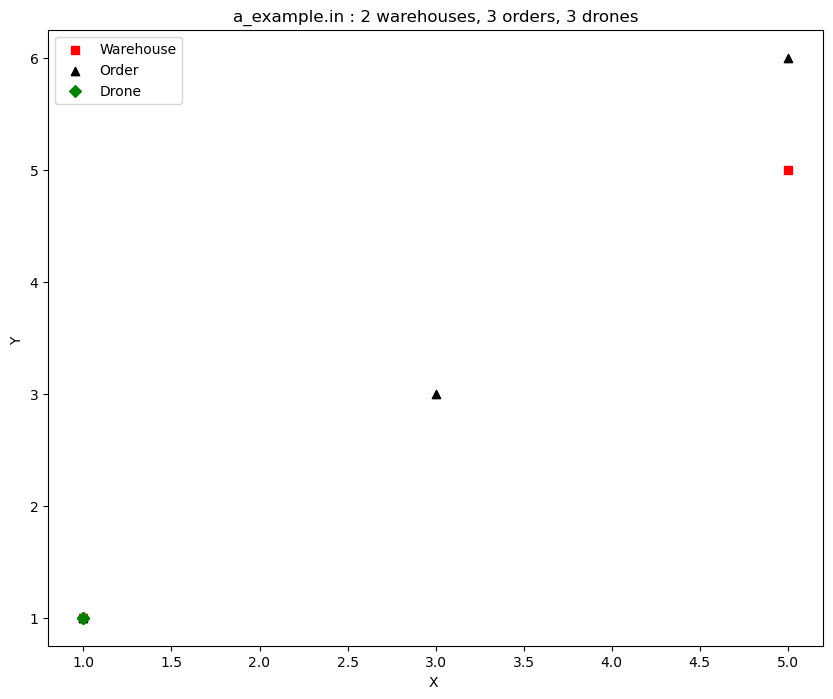

In [85]:
# Visualiser les données avec matplotlib et numpy

import matplotlib.pyplot as plt
import numpy as np

def plot_entities(entities, entity_type, color, marker='o'):
    x = [entity.location[0] for entity in entities]
    y = [entity.location[1] for entity in entities]
    plt.scatter(x, y, c=color, marker=marker, label=entity_type)

# Créer un nouveau graphique
plt.figure(figsize=(10, 8))

# Tracer les entrepôts en bleu
plot_entities(simulation_a.warehouses, 'Warehouse', 'red', marker='s')

# Tracer les commandes en rouge
plot_entities(simulation_a.orders, 'Order', 'black', marker='^')

# Tracer les drones en vert
plot_entities(simulation_a.drones, 'Drone', 'green', marker='D')

# Définir les labels et le titre
plt.xlabel('X ')
plt.ylabel('Y ')
plt.title(f'a_example.in : {len(simulation_a.warehouses)} warehouses, {len(simulation_a.orders)} orders, {len(simulation_a.drones)} drones')

# Afficher la légende
plt.legend()

# Afficher le graphique
plt.show()

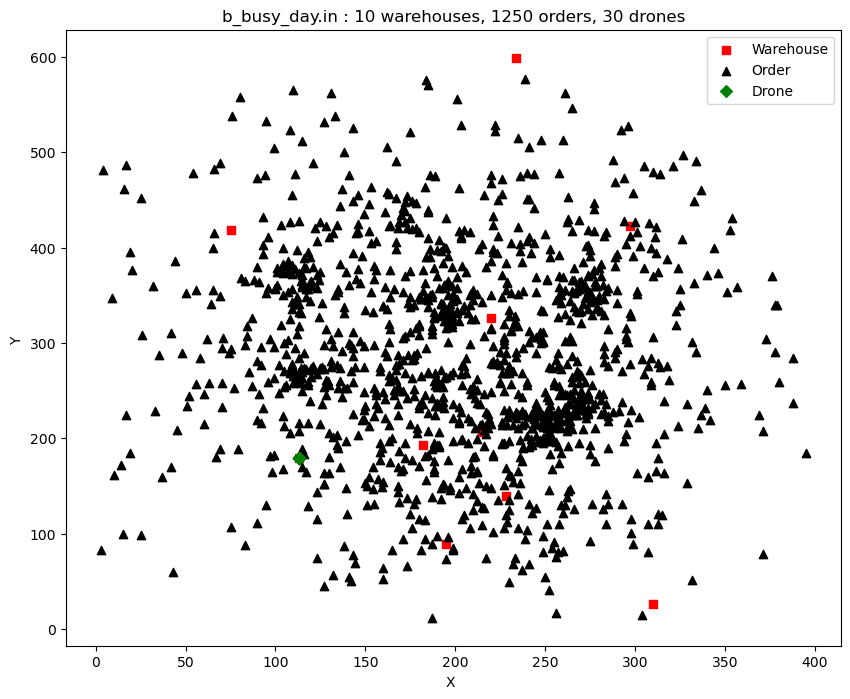

In [83]:

plt.figure(figsize=(10, 8))

plot_entities(simulation_b.warehouses, 'Warehouse', 'red', marker='s')
plot_entities(simulation_b.orders, 'Order', 'black', marker='^')
plot_entities(simulation_b.drones, 'Drone', 'green', marker='D')

plt.xlabel('X ')
plt.ylabel('Y ')
plt.title(f'b_busy_day.in : {len(simulation_b.warehouses)} warehouses, {len(simulation_b.orders)} orders, {len(simulation_b.drones)} drones')

plt.legend()

plt.show()


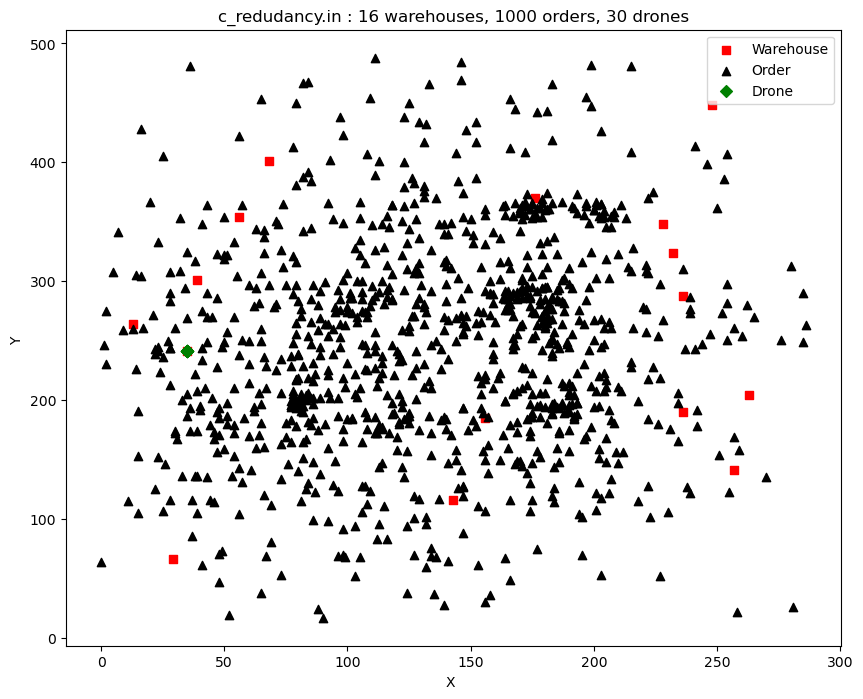

In [84]:

plt.figure(figsize=(10, 8))

plot_entities(simulation_c.warehouses, 'Warehouse', 'red', marker='s')
plot_entities(simulation_c.orders, 'Order', 'black', marker='^')
plot_entities(simulation_c.drones, 'Drone', 'green', marker='D')

plt.xlabel('X ')
plt.ylabel('Y ')
plt.title(f'c_redudancy.in : {len(simulation_c.warehouses)} warehouses, {len(simulation_c.orders)} orders, {len(simulation_c.drones)} drones')

plt.legend()

plt.show()


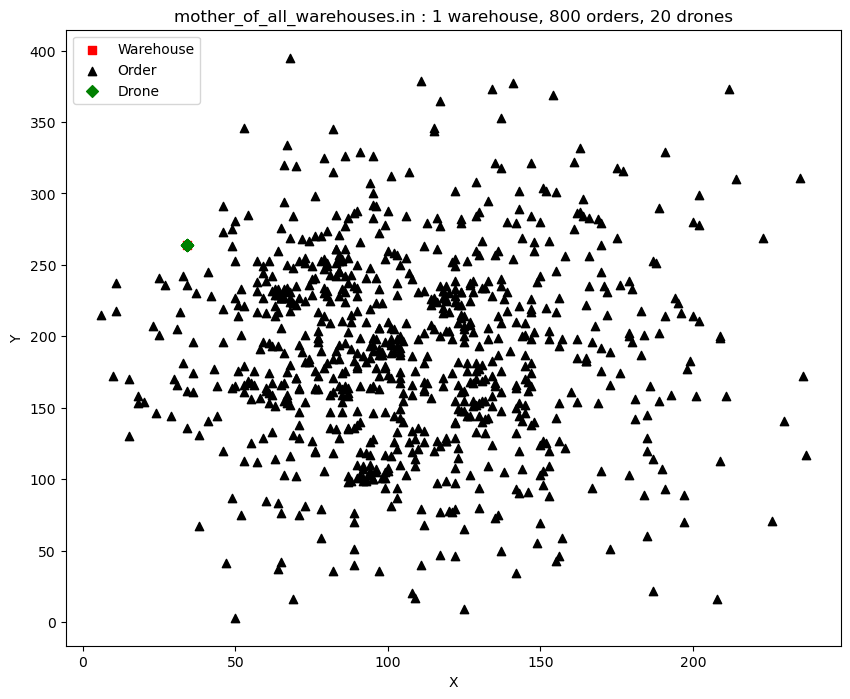

In [120]:

plt.figure(figsize=(10, 8))

plot_entities(simulation_d.warehouses, 'Warehouse', 'red', marker='s')
plot_entities(simulation_d.orders, 'Order', 'black', marker='^')
plot_entities(simulation_d.drones, 'Drone', 'green', marker='D')

plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'mother_of_all_warehouses.in : {len(simulation_d.warehouses)} warehouse, {len(simulation_d.orders)} orders, {len(simulation_d.drones)} drones')

plt.legend()

plt.show()


In [198]:
# je veux calculer la moyenne des poids des produits 

def moyenne_poids_produits(simulation):
    total_weight = 0
    for product_type in simulation.product_types:
        total_weight += product_type.weight
    return total_weight / len(simulation.product_types)

print(moyenne_poids_produits(simulation_d))
print(simulation_d.max_payload)
print(simulation_d.max_payload/moyenne_poids_produits(simulation_d))


63.816
200
3.134010279553717


In [168]:
# Je veux calculer l'écart type des poids des produits avec numpy

def ecart_type_poids_produits(simulation):
    moyenne = moyenne_poids_produits(simulation)
    total = 0
    for product_type in simulation.product_types:
        total += (product_type.weight - moyenne)**2
    return (total / len(simulation.product_types))**0.5

print(ecart_type_poids_produits(simulation_d))


31.33078588225965


In [184]:
# je veux calculer dans une commande en moyenne le nombre de produits différents

def moyenne_produits_differents(simulation):
    total = 0
    for order in simulation.orders:
        total += len(order.inventory)
    return total / len(simulation.orders)

print(moyenne_produits_differents(simulation_d))

7.67875


In [189]:
# je veux calculer dans une commande en moyenne le nombre d'articles

def moyenne_articles(simulation):
    total = 0
    for order in simulation.orders:
        total += sum(order.inventory.values())
    return total / len(simulation.orders)

print(moyenne_articles(simulation_d))

7.72125


In [197]:
# quelle est le poids maximal d'un type de produit

def poids_maximal_produit(simulation):
    max_weight = 0
    for product_type in simulation.product_types:
        if product_type.weight > max_weight:
            max_weight = product_type.weight
    return max_weight

print(poids_maximal_produit(simulation_d))

148


In [199]:
# quel est le poids minimal d'un type de produit

def poids_minimal_produit(simulation):
    min_weight = 1000
    for product_type in simulation.product_types:
        if product_type.weight < min_weight:
            min_weight = product_type.weight
    return min_weight

print(poids_minimal_produit(simulation_d))

2
